# Numerisk analyse av eksperimentelle målinger i FY1001

Denne notebooken er ment for å gi dere et utgangspunkt til å analysere målingene dere tok i Lab 3. Den inneholder litt av funksjonaliteten dere kommer til å trenge, men deler av koden må dere skrive selv. 

Den numeriske analysen kan deles inn i fire deler.

1. **Innhenting av data**- Analyse av eksperimentelle resultater forutsetter at man klarer å lese inn resultatene i et passende format.
2. **Fremstilling av resultater**- Dette gjelder både eksperimentelle og numeriske resultater. Denne notebooken vil gi en kort innføring i grafisk fremstilling, samt referanser til nyttige nettsider der dere kan lære mer.
3. **Enkel løsning av enkle differensialligninger**- Dere vil lære (mye) mer om numeriske metoder resten av studieløpet (i fag som "Bølgefysikk og Fluidmekanikk" (TFY4163) og "Introduksjon til Vitenskapelige Beregninger" (TMA4320)), men i dette prosjektet skal dere bruke den enkleste numeriske metoden til å løse differensialligninger. Ligningen dere skal løse er en forenklet versjon av den som faktisk beskriver bevegelsen til sylinderen. 
4. **Sammenligne numeriske løsninger med eksperimentelle resultater og bruke dette til å uthente relevant informasjon om fysikken i systemet**- Dette er den viktigste delen av prosjektet, og er det dere bør bruke mest tid på. Se prosjektbeskrivelsen for mer informasjon.


De første tre punktene er også forklart i de to numeriske øvingene i faget, så det kan være hensiktsmessig å titte på dem om dere står fast. 


La oss starte med å importere nødvendige bibliotek. Hvis dere har åpnet Jupyter Notebooken via Anaconda burde ikke dette være noe problem, men hvis dere ikke klarer å kjøre cellen nedenfor, ta kontakt med labveileder eller spør en medstudent.

In [85]:
# Importerer nødvendige bibliotek
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

## 1. Innhenting av data
Etter både lab 1 og 3 har dere rådataene i det foretrukne formatet til Tracker. Nå må dere lese disse resultatene inn i Python på en hensiktsmessig måte. Numerisk øving 1 dekker dette delvis, men her er par tips:
- Pass på at filen med rådata ligger i samme mappe som notebooken. Hvis dere har kontroll på hvordan filsystemet til PC-en deres fungerer er dette strengt tatt ikke nødvendig, men det er en sikker måte på at Python finner rådatafilen.
- ITGK (eller tilsvarende programmeringsfag) har muligens tips om hvordan man leser fra en fil i Python.  
`with open("navnet_ditt_paa_filen.txt", 'r') as f:` er en kommando som begynner prosessen å lese fra en tekstfil.
- Et annet alternativ er å bruke kommandoen `np.loadtxt("navnet_ditt_paa_filen.txt")` slik dere gjorde i lab 2.
- Det kan være hensiktsmessig å lage en funksjon som tar inn navnet på tekstfilen og returnerer antall linjer med datapunkter i filen. Kall dette antallet $M$.
- For å lage en numpy-array (liste), med $M$ nuller, som heter $x$ er kommandoen `x = np.zeros(M)`. 

In [2]:
# Skriv kode dere dere leser inn data fra eksperimentet til forskjellige variabler, t_array, x_array etc.
def read_from_file(filename, column=0):
    array = []
    with open(filename, "r") as f:
        for line in f:
            values = line.split("\t")
            array.append(float(values[column]))
    return np.array(array)

## 2. Fremstilling av resultater
La oss anta at vi har klart å lage en funksjon, `read_from_file`, som tar inn navnet på filen og hvilken kolonne den skal lese, og returnerer en numpy array som inneholder målingene. Vi bruker funksjonen til å lese inn tidsverdiene og $x$-posisjonene i måleserien.

In [3]:
t_array = read_from_file('rulledata.txt', column=0)
x_array = read_from_file('rulledata.txt', column=1)

Til å begynne med lager vi et veldig enkelt plott av de eksperimentelle resultatene vi leste inn.

In [74]:
#plt.plot(t_array, x_values)
#plt.show()

Dette er verken et pent eller særlig informativt plott. Kodeblokken under viser syntaksen for å gjøre det som kreves for å få et lesbart plott og setter på relevante aksetitler (med enheter). Se labheftet for mer informasjon om grafiske fremstillinger. 

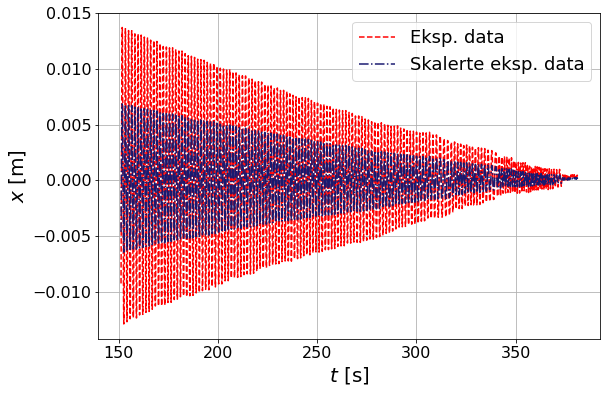

In [4]:
plt.figure(figsize=(9,6)) # Angir figurstørrelsen (bredde x høyde) i tommer

# Setter fargen til r=red, og endrer til stiplede linjer, label-nøkkelordet gir det man plotter et navn
plt.plot(t_array, x_array, color="r", linestyle="--", label="Eksp. data")

# For å vise at vi kan ha flere grafer i samme figur, la oss plotte samme graf som tidligere, men alle x-verdiene
# er delt på to. Vi bruker en litt mer fancy farge og linjestil.
plt.plot(t_array, x_array/2, color="midnightblue", linestyle="-.", label="Skalerte eksp. data")



plt.xlabel("$t$ [s]", fontsize=20) # Dollartegn rundt $t$ viser Python at det skal være mattefont
plt.ylabel("$x$ [m]", fontsize=20) # [m] angir at enheten til x er meter


# Øker skriftstørrelsen på tallverdiene på x- og y-aksen
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.legend(fontsize=18) # Gjør at navnet på alle navngitte plott vises i figuren


plt.grid() # Legger på et rutenett

# Den mest hensiktsmessige måten å lagre plot er ofte å gjøre det direkte i Python
# Nøkkelordet bbox_inches="tight" gjør at man kun lagrer plottet, ikke margene rundt
# Fjern # på linjen under for å lagre plottet
# plt.savefig("mitt_forste_plott.pdf", bbox_inches="tight") 

plt.show()

**Merk** Ovenfor er $x$ plottet som funksjon av $t$, men i den påfølgende numerikkdelen er vi interessert i vinkelutslaget $\phi$. Sjekk at dere forstår (ved bruk av ligningen $x(t) = l\mathrm{sin}\phi(t)$) hvordan man konverter $x$ til $\phi$ og vice versa.

Dere kommer til å plotte ___mye___ i løpet av studiet, så vi anbefaler at dere blir kjent med de forskjellige kommandoene og varierer farge, linjestil osv. Internett har stort sett svar på alle spørsmål, så dersom dere ønsker å endre på noe, Google i vei, så finner dere helt sikkert svar. Fysikknettsiden [NumFys](https://www.numfys.net/) har også korte plotte-notebooks, som for eksempel [denne](https://nbviewer.org/urls/www.numfys.net/media/notebooks/intermediate_plotting_final.ipynb), der dere kan lære mer.

Eksempelet ovenfor dekker alle formelle krav til grafiske fremstillinger i dette faget, så dere trenger ikke gjøre det mer komplisert hvis dere ikke ønsker, men ikke bruk akkurat samme farger og linjestil i rapporten deres.

## 3. Enkel løsning av enkle differensialligninger


På sitt mest grunnleggende, trenger man kun tre funksjoner for å løse diffligninger numerisk.


1. En funksjon $f$ som beskriver ligningen for $\ddot{\phi}$. $f$ avhenger av $\phi$ og $\dot{\phi}$, og avhenger også ofte av $t$ (men ikke for diffligningen vi studerer her). Definisjonen av $f$ blir da $f(\phi, \dot{\phi}) = \ddot{\phi}$. I prosjektet er det fullstendige uttrykket for $f$ gitt i ligning (26), men for enkelhets skyld kan dere starte med å implementere ligning 29, som er mindre komplisert. $f$ avhenger av fysiske parametre, $\omega_0$ og $\delta$, som den også må ta inn som argumenter. $\omega_0$ bestemmes av fysiske størrelser som dere målte på laben. En mulig form på $f$ kan være:

In [5]:
def f(phi, phi_R, phi_dot, w0, beta, delta, gamma):
    
    a = - w0**2*np.sin(phi)
    b = - 2*delta*phi_dot
    c = - np.pi*phi_R/(2*w0)*(w0**2*np.cos(phi)+gamma*(phi_dot)**2)*np.sign(phi_dot)
    d = - beta*(3*np.pi)*(4*w0)*(phi_dot)**2*np.sign(phi_dot)
    
    phi_double_dot = a + b + c + d
    return phi_double_dot


2. En stegfunksjon som relaterer $\phi$ og $\dot{\phi}$ ved tidspunkt $t +\Delta t$ til $\phi$ og $\dot{\phi}$ ved tidspunkt $t$. Dette svarer til ligning 38 i labheftet, og beskriver stegfunksjonen i Eulers metode. Bruk $f$ som dere fant i forrige punkt. Den utdelte koden (inkludert nedenfor) har en mer sofistikert stegfunksjon (som er beskrevet i appendikset), som dere kun må klare å bruke, ikke nødvendigvis å forstå. Den inneholder også alle dempingsleddene, ikke bare det lineære leddet i $v$. Denne stegfunksjonen heter `stepCN`.

 La oss skille mellom de to stegfunksjonene, `stepEuler` og `stepCN`. For at dere skal kunne sømløst bytte ut `stepEuler` med `stepCN`, må funksjonene ta inn de samme argumentente (i samme rekkefølge) og returnere de samme verdiene. `stepEuler` bør derfor se slik ut:

In [6]:
def stepEuler(phi, phi_dot, dt, w0, gamma, phiR, delta, beta):
    # Fyll in deres egen kode her som finner variablene next_phi og next_phi_dot
    next_phi = phi + phi_dot*dt
    next_phi_dot = phi_dot + f(phi, phiR, phi_dot, w0, beta, delta, gamma)*dt
    return next_phi, next_phi_dot

3. En overordnet funksjon som gradvis beregner tidstuviklingen til $\phi$ og $\dot{\phi}$ fra et tidspunkt $t_0$ til $t_{\text{f}}$, der den numeriske steglengden er $\Delta t$. Hvilken stegfunksjon dere bruker kan være et argument til denne funksjonen, samt andre nødvendige argumenter (som for eksempel initialverdiene til $\phi$ og $\dot{\phi}$). Funksjonen bør returnere arrays som inneholder verdiene av $\phi$ og $\dot{\phi}$ ved tidspunktene $t = 0, \Delta t, 2 \Delta t, ..., (N-1)\Delta t$, samt et array som inneholder tidspunktene. En mulig funksjonsdeklarasjon kan se slik ut:

In [7]:
def ODE_solver(dt, t_0, t_end, phi_0, phi_dot_0, w0, phiR, delta, beta, gamma, step_func=stepEuler):
    
    ts = np.arange(t_0, t_end, dt)
    phis = np.zeros_like(ts)
    phi_dots = np.zeros_like(ts)
    
    phis[0], phi_dots[0] = phi_0, phi_dot_0

    for i, t in enumerate(ts[:-1]): #now repeat CN(phi, phidot, dt, w0, gamma=1., phiR=0., delta=0., beta=.0):
        phis[i+1], phi_dots[i+1] = step_func(phis[i], phi_dots[i], dt, w0, gamma, phiR, delta, beta)
    return ts, phis, phi_dots

Nedenfor ligger koden for stegfunksjonen til Crank-Nicholson-metoden. Den gjennomfører ett tidssteg av den fullstendige diffligningen som er beskrevet i ligning 26.

In [8]:
''' 
NB! Denne kodeblokken inneholder kode dere trenger for å kjøre Crank-Nicholson-metoden.
Det er ikke forventet at dere skal sette dere inn i hva som skjer i denne koden, men dere må klare å bruke den.
'''
def derivative(x, w0, gamma, phiR, delta, beta):
    return np.array([x[1], -w0**2*np.sin(x[0])-(phiR*np.pi/(2*w0))*np.sign(x[1])*(w0**2*np.cos(x[0])+gamma*x[1]**2)-
                  2*delta*x[1]-beta*(3*np.pi/(4*w0))*x[1]**2*np.sign(x[1])])

def findInvJac(x, w0, gamma, phiR, delta, beta, dt):
    f00 = 1
    f01 = -(dt/2)
    f10 = -(dt/2)*(-w0**2*np.cos(x[0])+(phiR*np.pi/(2*w0))*np.sign(x[1])*w0**2*np.sin(x[0]))
    f11 = 1-(dt/2)*(-(phiR*np.pi/(2*w0))*np.sign(x[1])*2*gamma*x[1]-2*delta-2*beta*(3*np.pi/(4*w0))*np.absolute(x[1]) )
    return (1/(f00*f11-f01*f10))*np.array([[f11, -f01], [-f10, f00]])

def findf(x, xPrev, w0, gamma, phiR, delta, beta, dt):
    return x-xPrev-(dt/2)*(derivative(x, w0, gamma, phiR, delta, beta)+derivative(xPrev, w0, gamma, phiR, delta, beta))

def NewtonMethod(x, xPrev, w0, gamma, phiR,delta, beta, dt):
    return x-np.matmul(findInvJac(x, w0, gamma, phiR, delta, beta, dt), findf(x, xPrev, w0, gamma, phiR, delta, beta, dt))

def careFullStep(xPrev, w0, gamma, phiR, delta, beta, dt, n):
    nIntervalls = n
    dt = dt/nIntervalls

    k = np.empty((4, 2))
    x = np.empty((2, 2))
    x[0] = np.copy(xPrev)
    for i in range(nIntervalls):
        k[0] = derivative(x[0], w0, gamma, phiR, delta, beta)
        x[1] = x[0]+(dt/2)*k[0]
        k[1] = derivative(x[1], w0, gamma, phiR, delta, beta)
        x[1] = x[0]+(dt/2)*k[1]
        k[2] = derivative(x[1], w0, gamma, phiR, delta, beta)
        x[1] = x[0]+dt*k[2]
        k[3] = derivative(x[1], w0, gamma, phiR, delta, beta)
        x[0] += (dt/6)*(k[0]+2*k[1]+2*k[2]+k[3])
    return x[0]

def stepCN(phi, phidot, dt, w0, gamma=1., phiR=0., delta=0., beta=.0):
    """
    :param phi: float
        The previous value of phi
    :param phidot: float
        The previous value of phidot
    :param dt: float
        Fixed step size
    :param w0: float
        Undamped resonance-frequency of the harmonic oscillator
    :param gamma: float
        Factor incorporating the geometry of the oscillating object, defaults to 1
    :param phiR: float
        Zeroth order in phidot damping strength, defaults to 0
    :param delta: float
        First order in phidot damping strength, defaults to 0
    :param beta: float
        Second order in phidot damping strength, defaults to 0        
    :return x[0]: float
        The next value of phi after dt time has passed
    :return x[1]: float
        The next value of phidot after dt time has passed
    :return counter: int
        NB! This variable is commented out, but can be reintroduced if you need help debugging your code.
        The number of iterations of Newtons method. If counter=-1 the derivative is non-continuous on the interval 
        or if counter=-2 The Newtons-method is non-converging, and several iterations of a fourth-order RK4 has 
        been employed instead        
    """
    xPrev = np.array([phi, phidot])
    x = xPrev+dt*derivative(xPrev, w0, gamma, phiR, delta, beta)
    counter = 0
    tol=1e-15 # Tolerance of Newtons method, default value 1e-15
    while np.amax(np.absolute((findf(x, xPrev, w0, gamma, phiR, delta, beta, dt)))) > tol or counter < 1:
        if (np.sign(x[1] * xPrev[1]) == -1) and counter > 2 :
            return careFullStep(xPrev, w0, gamma, phiR, delta, beta, dt, 10)   #, -1
        x = NewtonMethod(x, xPrev, w0, gamma, phiR, delta, beta, dt)
        counter += 1
        if counter >= 10:
            return careFullStep(xPrev, w0, gamma, phiR, delta, beta, dt, 100)   #, -2
    return x[0], x[1]   #, counter

### 3.1 Oppgave 2b) og 2c)
Nå som dere har implementert koden beskrevet ovenfor, har dere alle nødvendige redskaper til å gjøre oppgave 2b) og 2c) som beskrevet i prosjektbeskrivelsen. Det kan være hensiktsmessig å gjøre denne oppgaven her før dere går videre til kurvetilpasning og oppgave.

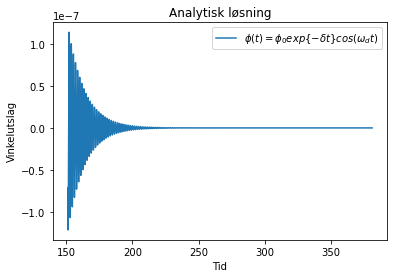

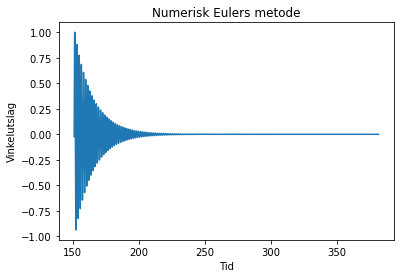

In [127]:
# Denne blokken kan inneholde oppgave 2b) og/eller 2c)

# 2b)
t_values = read_from_file("rulledata.txt", 0)
x_values = read_from_file("rulledata.txt", 1)

dt = 0.001

R = 0.45 # meter
r = 0.03 # meter
g = 9.80665 # meter/sekund/sekund
l = R - r # meter
c = 0.5 
m = 2.04 # kg
gamma = 1 / (1+c)
w0 = np.sqrt(gamma * g / l)

phi_values = np.arcsin(x_values/l)

phi_0 = phi_values[0]
phi_dot_0 = (phi_values[1] - phi_values[0]) / dt

d = 0.0000001
beta_bar = 0.000001

phiR = d / r * 2 * w0 / np.pi
beta = 4 * gamma / (3 * np.pi) * w0 * l / m * beta_bar
delta = 0.08

phiR = 0
beta = 0


""" Analytic solution
"""
def analytic_solution(t):
    w_d = np.sqrt(w0 * w0 - delta * delta)
    return phi_0 * np.exp(-delta * t) * np.cos(w_d * t)

def phi_analytic(t, phi0, w0, delta):
    return phi0*np.exp(-delta*t)*np.cos(np.sqrt(w0**2-delta**2)*t)

plt.figure(1)
plt.title("Analytisk løsning")
plt.plot(t_values, phi_analytic(t_values, phi_0, w0, delta))
plt.legend(["$\phi(t)=\phi_0 exp\{-\delta t\}cos(\omega_d t)$"])
plt.xlabel("Tid")
plt.ylabel("Vinkelutslag")

""" Eulers metode
"""
t_num_array, phi_num_array, phi_dot_num_array = ODE_solver(dt, t_array[0], t_array[-1], phi_0, phi_dot_0, w0, phiR, delta, beta, gamma)
plt.figure(2)
plt.title("Numerisk Eulers metode")
plt.plot(t_num_array, phi_num_array)
plt.xlabel("Tid")
plt.ylabel("Vinkelutslag")

""" CN_metode
"""
def CN_metode_plot(beta=4 * gamma / (3 * np.pi) * w0 * l / m * .000001, phiR=d / r * 2 * w0 / np.pi, delta=0.08, title='Kart'):
    dt = 0.01

    print("PhiR", phiR)
    print("beta", beta)
    print("delta", delta)

    ts, phis, phi_dots = ODE_solver(dt, t_array[0], t_array[-1], phi_0, phi_dot_0, w0, phiR, delta, beta, gamma, step_func=stepCN)
    plt.figure(3)
    plt.title(f'Numerisk CN-metode gjett: $\phi_R={phiR}, \\beta={beta}, \\delta={delta}$')
    plt.plot(t_values, phi_values * 30)
    plt.plot(ts, phis)
    #plt.plot(t_values, phi_analytic(t_values, phi_0, w0, delta))
    plt.xlabel("Tid")
    plt.ylabel("Vinkelutslag")
    plt.savefig(title)

PhiR 8e-06
beta 2e-07
delta 0.08


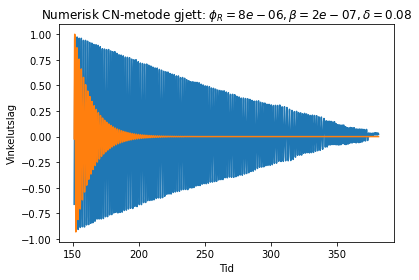

In [128]:
CN_metode_plot(phiR=8e-06, beta=2e-07, delta=8e-02, title='initialGuess.pdf')

PhiR 8e-06
beta 2e-07
delta 0.016


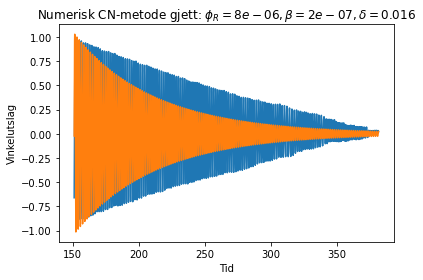

In [129]:
CN_metode_plot(phiR=8e-06, beta=2e-07, delta=16e-03, title='highDelta.pdf')

PhiR 8e-06
beta 2e-20
delta 0.016


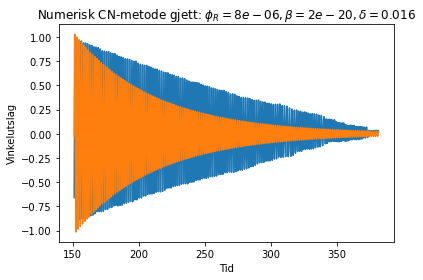

In [130]:
# beta har sikkert null å si
CN_metode_plot(phiR=8e-06, beta=2e-20, delta=16e-03, title='veryLowBeta.pdf')

PhiR 1e-20
beta 2e-20
delta 0.016


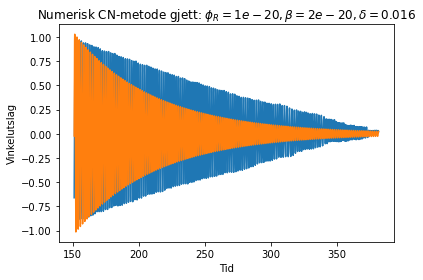

In [131]:
CN_metode_plot(phiR=1e-20, beta=2e-20, delta=16e-03, title='onlyHighDelta.pdf')

PhiR 1e-20
beta 0.02
delta 1.6e-29


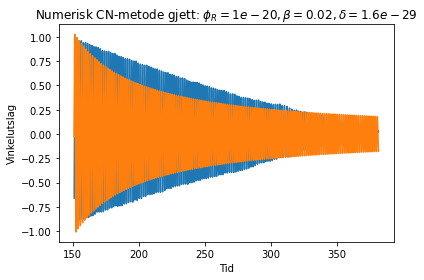

In [132]:
CN_metode_plot(phiR=1e-20, beta=2e-2, delta=16e-30, title='onlyHighBeta.pdf')

PhiR 0.0039
beta 2e-30
delta 1.6e-29


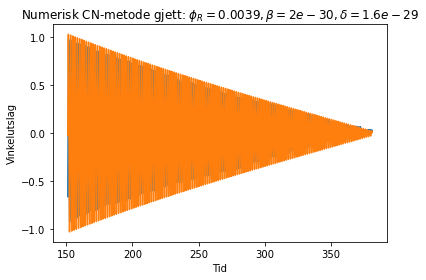

In [133]:
CN_metode_plot(phiR=39e-4, beta=2e-30, delta=16e-30, title='onlyHighPhiR.pdf')

## 4. Kurvetilpasning
Nå som vi har en stabil, rask, differensialligningsløser, kan vi utforske de forskjellige dempingsmekanismene nærmere. Ved å simulere bevegelsen til sylinderen for forskjellige verdier av $\delta, \beta$ og $\phi_R$ kan man se hvor godt numeriske resultater samsvarer med eksperimentelle målinger.

Dere står fritt til å velge selv hvordan dere vil gå frem her. Det enkleste er sannsynligvis å eksperimentere litt med forskjellige størrelsesordner for de forskjellige parameterene en og en, slik at dere har et røft anslag på hvor store de må være for å gi en realistisk demping. Etterpå, finn verdier for $\delta, \beta$, og $\phi_R$ som gjør at de numeriske resultatene samsvarer best mulig med de eksperimentelle verdiene. For å evalulere samsvaret, plott de numeriske resultatene i samme figur som de eksperimentelle verdiene og observer i hvor stor grad grafene overlapper. 



__Siste merknad:__ Dere kan også bruke funksjonen `scipy.optimize.curve_fit` fra biblioteket `scipy`. Merk at dette ligger et godt stykke utenfor vanlig ITGK-pensum så vi forventer __ikke__ at dere gjør det. Det holder å eksperimentere med forskjellige parametre og evaluere samsvaret på øyemål. 